In [7]:
import os
import pandas as pd
import pathlib
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import seaborn as sns

from collections import namedtuple
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ast import literal_eval
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from presolve_datasets import *
from networks import *

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [8]:
# writer = SummaryWriter(f'runs/cartpole-{time.strftime("%Y%m%d-%H%M%S")}')
# %reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 22712), started 10 days, 22:36:28 ago. (Use '!kill 22712' to kill it.)

## Define Dataset and DataLoader

In [14]:
from trajectory_utils import create_idx
from cartpole_dynamics import cartpole_dynamics_constraints

# NLP Parameters
nx, nu, N = 4, 1, 41
idx = create_idx(nx, nu, N)

Z = np.random.rand(nx*N + nu*(N-1))
# print(Z[idx.X])

xg = np.array([0, np.pi, 0, 0])

dt = 0.05
tf = 2.0

mc = 1.0
mp = 0.2
l = 0.5

# params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5)
CartpoleParams = namedtuple('CartpoleParams', ['dt', 'tf', 'N','idx', 'xg', 'mc', 'mp', 'l'])
params = CartpoleParams(dt, tf, N, idx, xg, mc, mp, l)
path = pathlib.Path(r'data\presolves\cartpole_DIRCOL_5000.csv')

cartpole_warmstart = POCPSolver(path, nlp_params=params, eq_constraint_fn=cartpole_dynamics_constraints)
# cartpole_warmstart = POCPSolver(path, nlp_params=params)



# hermite_simpson(params, x1, x2, u=np.array([0]), dt=0.1)

## Train or load a model

In [16]:
import cProfile

cProfile.run('cartpole_warmstart.train(5)')
# cartpole_warmstart.train(5)

# path = pathlib.Path(r'C:\Users\AiPEX-WS4\Documents\AiPEX-Projects\warmstarting_NLPs\models\cartpole_model1.pth')
# cartpole_warmstart.load_model(path)

Fitting NLP data with neural network...


  0%|          | 0/5 [00:30<?, ?it/s]

         341899 function calls (337485 primitive calls) in 30.631 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      106    0.000    0.000    0.000    0.000 <frozen _collections_abc>:341(__subclasshook__)
      215    0.000    0.000    0.001    0.000 <frozen abc>:117(__instancecheck__)
      117    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
       25    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen ntpath>:107(join)
        3    0.000    0.000    0.000    0.000 <frozen ntpath>:179(splitroot)
        1    0.000    0.000    0.000    0.000 <frozen ntpath>:236(split)
        1    0.000    0.000    0.000    0.000 <frozen ntpath>:35(_get_bothseps)
        1    0.000    0.000    0.000    0.000 <frozen os>:200(makedirs)
      2/1    0.004    0.002   30.626   30.626 <string>:1(<module>)
      106    0.000    0.0

KeyboardInterrupt: 

In [ ]:
cartpole_warmstart.save_model(f'models/cartpole-{time.strftime("%Y%m%d-%H%M%S")}.pth')

Model saved successfully!


## Visualize the MLP Generated Warm-Start

Model loaded successfully!


c:\Users\AiPEX-WS4\Documents\AiPEX-Projects\warmstarting_NLPs\networks.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


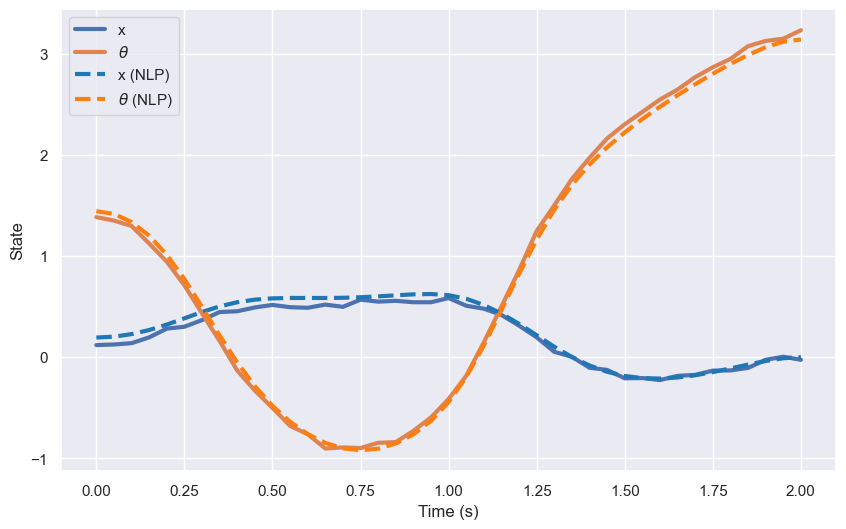

In [ ]:
path = pathlib.Path(r'models\cartpole-20240808-165602.pth')
cartpole_warmstart.load_model(path)
cartpole_warmstart.compare_trajectories(2)


Model loaded successfully!


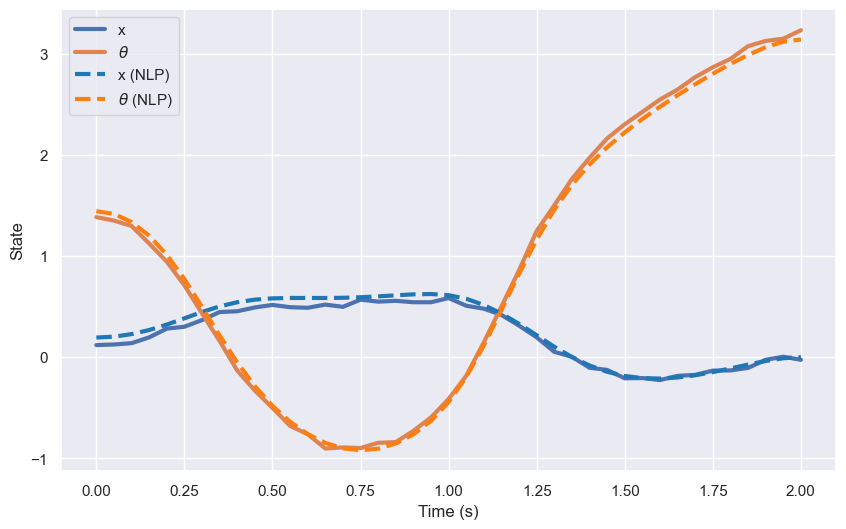

In [ ]:
path = pathlib.Path(r'models\cartpole-20240808-165541.pth')
cartpole_warmstart.load_model(path)

cartpole_warmstart.compare_trajectories(2)


## Go through the test dataset and store the MLP generated warmstart trajectories

In [ ]:
# cartpole_warmstart.store_warmstart_trajectories('data/warmstart_trajectories/cartpole_test.csv')

## Visualize histograms for solve time

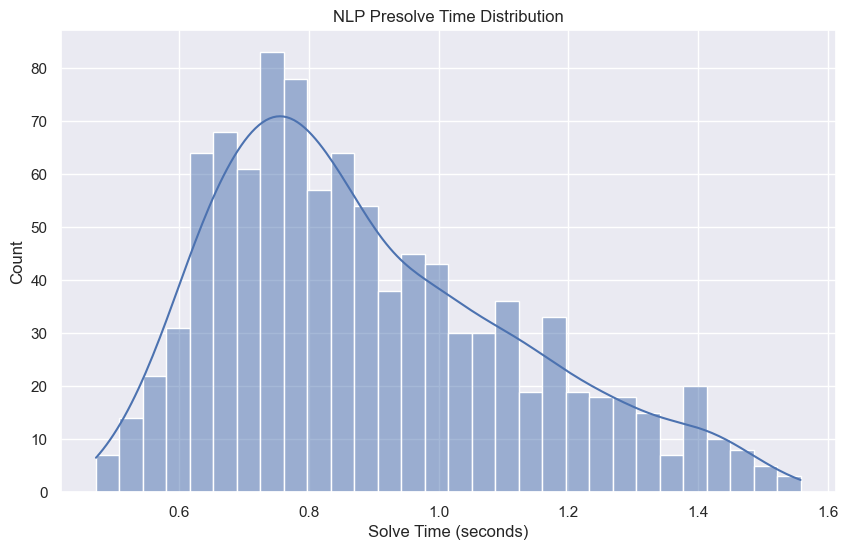

In [ ]:
# cartpole_warmstart.compare_solve_time()

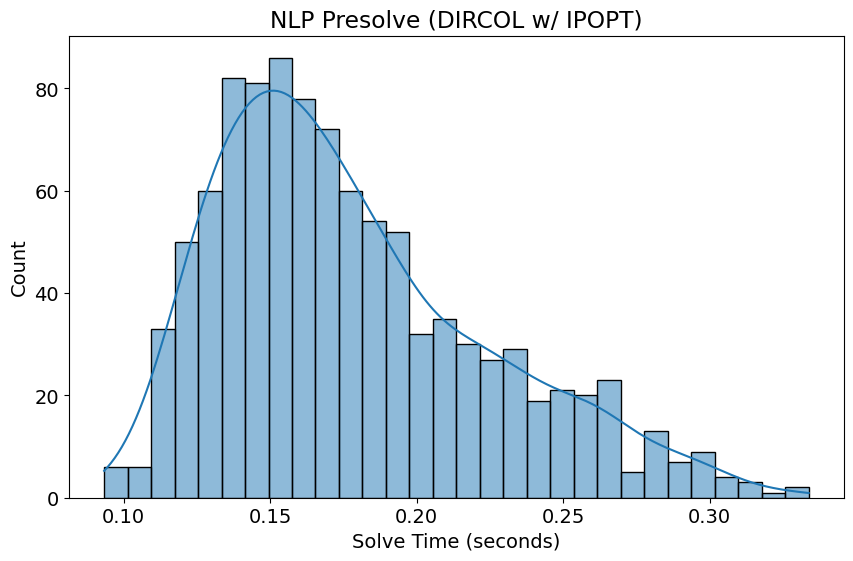

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.histplot(warmstart_df['solve_time_sec']/5, bins=30, kde=True)
# plt.xlabel('Solve Time (seconds)')
# plt.ylabel('Count')
# plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
# plt.show()